In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
params = {
    'batch_size': 200,
    'learning_rate': 0.001,
    'epochs': 10,
    'log_interval': 10
}

In [4]:
def load_and_transform_dataset():

    trans = transforms.Compose([
            transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    loaded_trdata = datasets.MNIST('../data', train = True, download = True, transform = trans)
    loaded_tsdata = datasets.MNIST('../data', train = False, transform = trans)
    trdata = DataLoader(loaded_trdata, batch_size=params['batch_size'], shuffle=True)
    tsdata = DataLoader(loaded_tsdata, batch_size=params['batch_size'], shuffle = False)
    
    return trdata, tsdata

In [5]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    ReLU
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel)
    ReLU
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    ReLU
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.clayer1 = nn.Sequential(\
                                    nn.Conv2d(1, 6, kernel_size = 5, stride = 1),\
                                    nn.ReLU(),\
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.clayer2 = nn.Sequential(\
                            nn.Conv2d(6, 16, kernel_size = 5, stride = 1),\
                            nn.ReLU(),\
                            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fully_connected_clayer = nn.Sequential(\
                            nn.Conv2d(16, 120, kernel_size = 5),\
                            nn.ReLU())
        #The fifth layer (C5) is a fully connected convolutional layer with 120 feature 
        #maps each of size 1×1. Each of the 120 units in C5 is connected to all the 400 
        #nodes (5x5x16) in the fourth layer S4.
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.clayer1(x)
        x = self.clayer2(x)
        x = self.fully_connected_clayer(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [6]:
model = LeNet5()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'])

LeNet5(
  (clayer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clayer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_clayer): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
train_data, test_data = load_and_transform_dataset()

In [10]:
# training loop - keep storing the loss and accuracy too
model.train()
losses = []
accs = []
total_imgs_in_dataset = len(train_data.dataset)
"""
By default all the modules are initialized to train mode (self.training = True). 
Also be aware that some layers have different behavior during train/and evaluation
(like BatchNorm, Dropout) so setting it matters. Also as a rule of thumb for 
programming in general, try to explicitly state your intent and set 
model.train() and model.eval() when necessary.

"""
for epoch in range(0, params['epochs']):
    for batch_idx, (data, target) in enumerate(train_data):
        
        
        # one forward pass
        model_output = model(data)
        #print(model_output)
        train_loss = criterion(model_output, target)
        losses.append(train_loss.item())
        
        # backward pass and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # compare predictions
        total_preds = target.size(0)
        _, preds = torch.max(model_output.data, 1) # 1 indicates we need max values for each "row"
        # Returns a namedtuple (values, indices) where values is the 
        # maximum value of each row of the input tensor in the given 
        # dimension dim. And indices is the index location of each maximum value found (argmax).
        matched = (preds==target).sum().item()
        accs.append(matched/total_preds)

        if batch_idx % params['log_interval'] ==0:
            processed_imgs = batch_idx*len(data) # no. of batches * no of images in each batch
            percentage_processed = processed_imgs*100.0/total_imgs_in_dataset
            print('Train Epoch : {} [{}/{}] ({:.0f} %)  Loss: {:.6f}  Train_acc: {:2f}'.format\
                 ((epoch+1), processed_imgs, total_imgs_in_dataset, percentage_processed,\
                 train_loss.item(), (matched/total_preds)*100.0))

/home/sandipan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch : 1 [0/60000] (0 %)  Loss: 2.301035  Train_acc: 8.000000
Train Epoch : 1 [2000/60000] (3 %)  Loss: 2.087705  Train_acc: 53.000000
Train Epoch : 1 [4000/60000] (7 %)  Loss: 1.397215  Train_acc: 73.500000
Train Epoch : 1 [6000/60000] (10 %)  Loss: 0.771373  Train_acc: 80.000000
Train Epoch : 1 [8000/60000] (13 %)  Loss: 0.555987  Train_acc: 83.500000
Train Epoch : 1 [10000/60000] (17 %)  Loss: 0.435411  Train_acc: 86.500000
Train Epoch : 1 [12000/60000] (20 %)  Loss: 0.427415  Train_acc: 84.500000
Train Epoch : 1 [14000/60000] (23 %)  Loss: 0.339552  Train_acc: 90.500000
Train Epoch : 1 [16000/60000] (27 %)  Loss: 0.416059  Train_acc: 88.500000
Train Epoch : 1 [18000/60000] (30 %)  Loss: 0.324899  Train_acc: 91.000000
Train Epoch : 1 [20000/60000] (33 %)  Loss: 0.294638  Train_acc: 90.000000
Train Epoch : 1 [22000/60000] (37 %)  Loss: 0.237819  Train_acc: 93.000000
Train Epoch : 1 [24000/60000] (40 %)  Loss: 0.170055  Train_acc: 97.000000
Train Epoch : 1 [26000/60000] (43 %) 

Train Epoch : 4 [40000/60000] (67 %)  Loss: 0.050799  Train_acc: 99.500000
Train Epoch : 4 [42000/60000] (70 %)  Loss: 0.074542  Train_acc: 97.000000
Train Epoch : 4 [44000/60000] (73 %)  Loss: 0.033059  Train_acc: 99.500000
Train Epoch : 4 [46000/60000] (77 %)  Loss: 0.078786  Train_acc: 97.500000
Train Epoch : 4 [48000/60000] (80 %)  Loss: 0.050011  Train_acc: 99.000000
Train Epoch : 4 [50000/60000] (83 %)  Loss: 0.028542  Train_acc: 99.500000
Train Epoch : 4 [52000/60000] (87 %)  Loss: 0.063381  Train_acc: 98.500000
Train Epoch : 4 [54000/60000] (90 %)  Loss: 0.101269  Train_acc: 98.000000
Train Epoch : 4 [56000/60000] (93 %)  Loss: 0.025558  Train_acc: 99.500000
Train Epoch : 4 [58000/60000] (97 %)  Loss: 0.046320  Train_acc: 98.500000
Train Epoch : 5 [0/60000] (0 %)  Loss: 0.044064  Train_acc: 99.000000
Train Epoch : 5 [2000/60000] (3 %)  Loss: 0.028953  Train_acc: 99.500000
Train Epoch : 5 [4000/60000] (7 %)  Loss: 0.011497  Train_acc: 100.000000
Train Epoch : 5 [6000/60000] (10 

Train Epoch : 8 [20000/60000] (33 %)  Loss: 0.022246  Train_acc: 99.000000
Train Epoch : 8 [22000/60000] (37 %)  Loss: 0.033699  Train_acc: 99.000000
Train Epoch : 8 [24000/60000] (40 %)  Loss: 0.004226  Train_acc: 100.000000
Train Epoch : 8 [26000/60000] (43 %)  Loss: 0.018505  Train_acc: 99.500000
Train Epoch : 8 [28000/60000] (47 %)  Loss: 0.021613  Train_acc: 98.500000
Train Epoch : 8 [30000/60000] (50 %)  Loss: 0.019382  Train_acc: 99.000000
Train Epoch : 8 [32000/60000] (53 %)  Loss: 0.044150  Train_acc: 98.500000
Train Epoch : 8 [34000/60000] (57 %)  Loss: 0.013950  Train_acc: 100.000000
Train Epoch : 8 [36000/60000] (60 %)  Loss: 0.081864  Train_acc: 98.000000
Train Epoch : 8 [38000/60000] (63 %)  Loss: 0.012259  Train_acc: 99.500000
Train Epoch : 8 [40000/60000] (67 %)  Loss: 0.007060  Train_acc: 100.000000
Train Epoch : 8 [42000/60000] (70 %)  Loss: 0.018263  Train_acc: 100.000000
Train Epoch : 8 [44000/60000] (73 %)  Loss: 0.011471  Train_acc: 100.000000
Train Epoch : 8 [460

In [11]:
#testing loop
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for data, target in test_data:
        output = model(data)
        _, preds = torch.max(output.data, 1)
        correct += (preds == target).sum().item()
        total += target.size(0)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


/home/sandipan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model on the 10000 test images: 99.0 %


In [12]:
from matplotlib import pyplot as plt

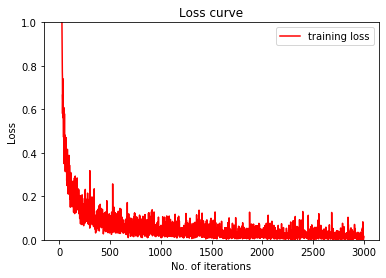

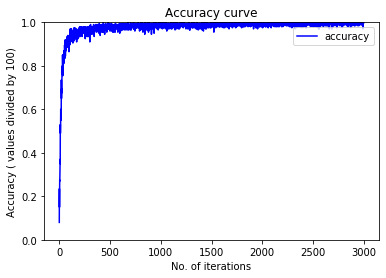

In [13]:
#loss curve (training)
noOfIters = [x for x in range(0,len(losses))]
fig1 = plt.figure()
plt.plot(noOfIters, losses, 'r', label = 'training loss')
plt.title("Loss curve")
plt.legend(loc = 'upper right')
plt.ylim(0, 1)
plt.ylabel('Loss');
plt.xlabel('No. of iterations')
plt.show()
fig1.savefig('loss curve.png')


fig2 = plt.figure()
# accuracy curve (training)
plt.plot(noOfIters, accs, 'b', label = 'accuracy')
plt.title("Accuracy curve")
plt.legend(loc = 'upper right')
plt.ylim(0, 1)
plt.ylabel('Accuracy ( values divided by 100)');
plt.xlabel('No. of iterations')
plt.savefig('accuracy.png')